Made on 24/04 for figure 6

In [1]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
from low_rank_rnns import rdm, romo, mante, dms, clustering, helpers, raposo
from low_rank_rnns import mante_regressions as mreg
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, homogeneity_score, r2_score, adjusted_rand_score
from scipy import stats
from sklearn.metrics import adjusted_mutual_info_score, f1_score

In [2]:
helpers.setup_matplotlib(release=True)
plt.rcParams['figure.figsize'] = (1.5, 1.5)

In [3]:
hidden_size = 4096
noise_std = 0.
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val, epochs = \
    mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_rank1_4096.pt', map_location='cpu'))


In [4]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()

# Positivity adjustments
n = -n
m = -m
colors = ['rebeccapurple', 'seagreen']

In [5]:
n_pops = 2
vecs = clustering.make_vecs(net)
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020)

In [6]:
r_ctx = mreg.compute_ctx_regressors(net, epochs[1][0], epochs[1][1])
r_sc = mreg.compute_choice_sensory_regressors(net)
reg_full = np.hstack([r_ctx, r_sc])
print(reg_full.shape)

choice R2=0.5379051778816064
sensory R2=0.49347023027031583
(4096, 5)


In [17]:
z2, _ = clustering.gmm_fit(reg_full, 2, algo='bayes', n_init=50, random_state=2020, mean_precision_prior=1e4,
                          weight_concentration_prior_type='dirichlet_distribution',
                          weight_concentration_prior=1e7)
z2 = -(z2 - 1)  # just invert the 2 populations

Text(0, 0.9, '$\\beta_i^{choice}$')

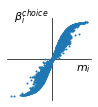

In [20]:
fig, ax = plt.subplots()
ax.scatter(m, r_sc[:, 2], zorder=100, s=1)
ax.set(xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$m_i$', horizontalalignment='right', x=1)
ax.set_ylabel('$\\beta_i^{choice}$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_mante_mrchoice.pdf')

Text(0, 0.9, '$\\beta_i^{ctxA}$')

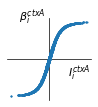

In [21]:
fig, ax = plt.subplots()
ax.scatter(wi_ctx1, r_ctx[:, 0], zorder=100, s=1)
ax.set(xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$I_i^{ctxA}$', horizontalalignment='right', x=1)
ax.set_ylabel('$\\beta_i^{ctxA}$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_mante_irctx.pdf')

Warning: cell below launches heavy computations

In [21]:
%%time
clusters_nums = (2, 3, 4, 5, 6)
aris = [clustering.clustering_stability(reg_full, k, 20, algo='gmm') for k in clusters_nums]

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 50 did not converge. Try different init parameters, or increase max_iter, tol or

CPU times: user 5.61 s, sys: 225 ms, total: 5.84 s
Wall time: 4min 49s


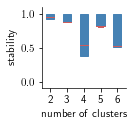

In [22]:
ax = clustering.boxplot_clustering_stability(reg_full, clusters_nums, aris=aris)
#plt.savefig('figures/6_mante_stab.pdf', bbox_inches='tight')

Text(0, 0.9, '$\\beta_i^{ctxB}$')

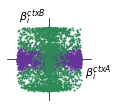

In [22]:
fig, ax = plt.subplots()
for i in range(2):
    ax.scatter(reg_full[z2==i, 0], reg_full[z2==i, 1], c=colors[i], zorder=100, s=1)
ax.set(xticks=[], yticks=[], xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$\\beta_i^{ctxA}$', horizontalalignment='right', x=1.25)
ax.set_ylabel('$\\beta_i^{ctxB}$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_mante_ctxclust.pdf', bbox_inches='tight')

Text(0, 0.9, '$\\beta_i^B$')

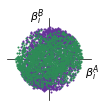

In [23]:
fig, ax = plt.subplots()
for i in range(2):
    ax.scatter(reg_full[z==i, 2], reg_full[z==i, 3], c=colors[i], zorder=100, alpha=1, s=1)
ax.set(xticks=[], yticks=[], xlim=(-.1, .1), ylim=(-.1, .1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$\\beta_i^A$', horizontalalignment='right', x=1.1)
ax.set_ylabel('$\\beta_i^B$', horizontalalignment='right', y=.9, rotation='horizontal')
#plt.savefig('figures/6_mante_Iclust.pdf')